## Multi-temporal SAR RGB composite for 2018

### Objective 

Multi-year SAR data is used to study the seasonal dynamic of the snow melt patterns.

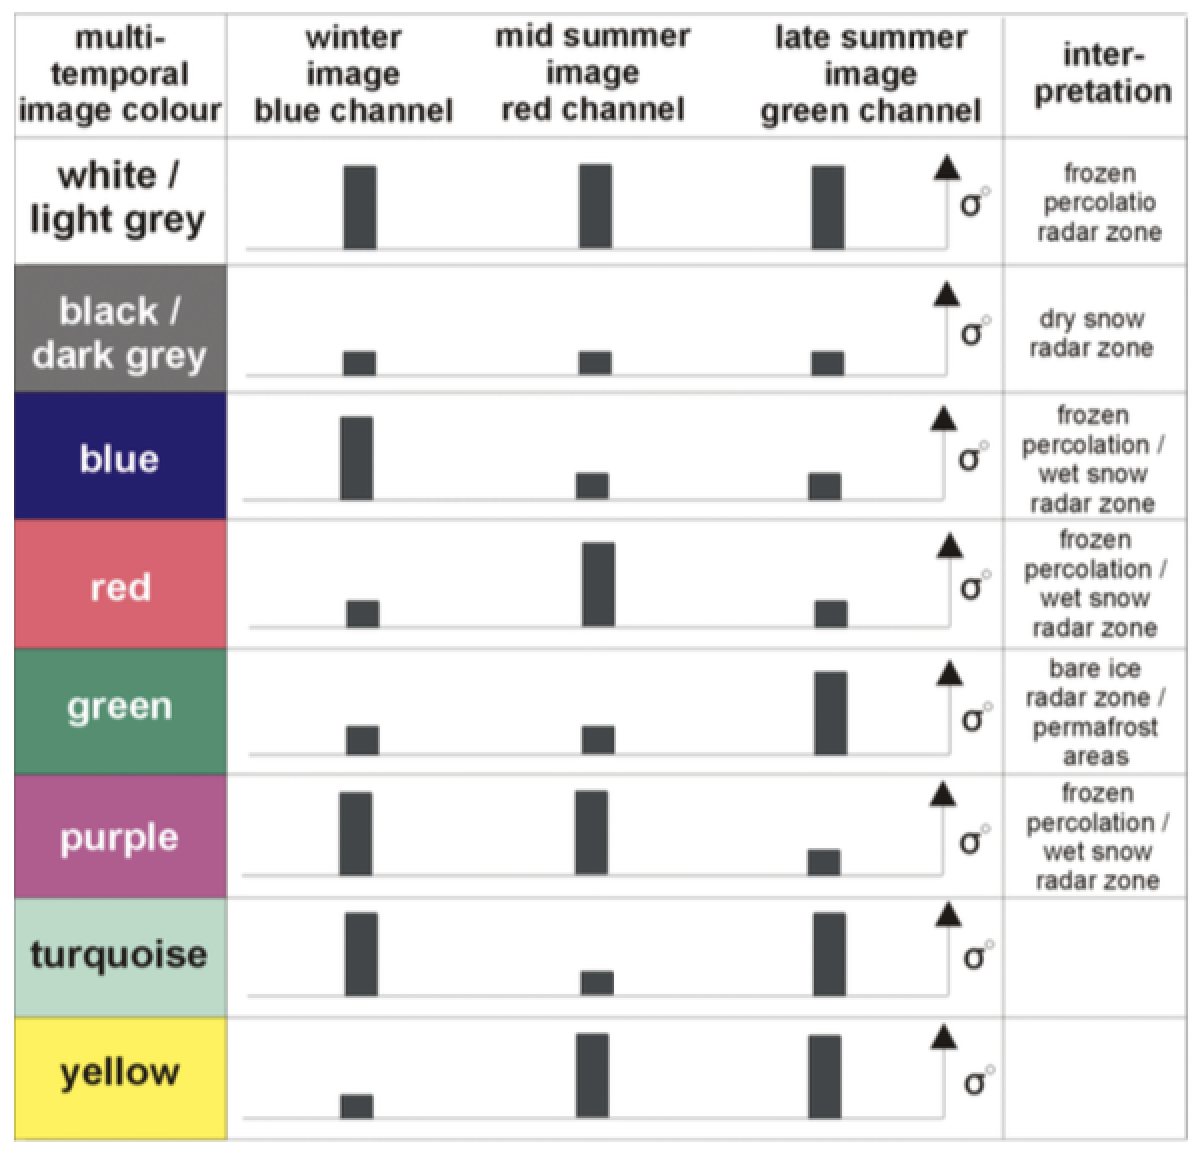

In [29]:
from IPython.display import Image
Image(filename='resources/multitemporal-rgb.png', width=350, height=350) 

Colours scheme for the multi-temporal SAR images (modified after Partington 1998). Vertical bars indicate backscatter coefficients. The right column gives reference to the radar glacier zones

Braun, M. & Rau, F. (2000): Using a multi-year data archive of ERS SAR imagery for the monitoring of firn line positions and ablation patterns on the King George island ice cap (Antarctica). In: Proceedings EARSeL SIG- Workshop Land Ice and Snow, June 16 - 17, 2000, Dresden, Germany.

### The Python modules required

In [30]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
os.environ['_CIOP_APPLICATION_PATH']=''
sys.path.append('/opt/anaconda/bin/')
import cioppy
ciop = cioppy.Cioppy()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap

import gc

from shapely.wkt import loads 
from shapely.geometry import box
from shapely.geometry import Point
from shapely import geometry

import osr
import ogr

import gdal
from geopandas import GeoDataFrame
import pandas as pd

sys.path.append(os.getcwd())
import ellip_snap_helpers

from PIL import Image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Discover the multi-season Sentinel-1 data

Define the time of interest:

In [31]:
tois = {'winter': { 'start_date': '2018-01-01T00:00:00', 'stop_date': '2018-01-31T23:59:59' },
        'mid_summer': { 'start_date': '2018-07-01T00:00:00', 'stop_date': '2018-07-31T23:59:59' },
        'late_summer': { 'start_date': '2018-08-15T00:00:00', 'stop_date': '2018-08-31T23:59:59' }}

In [32]:
for index, toi in enumerate(tois):
    print toi, 'from: ', tois[toi]['start_date'], 'to: ', tois[toi]['stop_date']

mid_summer from:  2018-07-01T00:00:00 to:  2018-07-31T23:59:59
late_summer from:  2018-08-15T00:00:00 to:  2018-08-31T23:59:59
winter from:  2018-01-01T00:00:00 to:  2018-01-31T23:59:59


Set the catalogue endpoint to Sentinel-1:

In [33]:
series = 'https://catalog.terradue.com/sentinel1/search'

Define the area of interest:

In [34]:
def extend_aoi(center_x, center_y, extent):
    
    polar_epsg = 3575 # 3995
    latlon_epsg = 4326
    
    center_polar = loads(convert_coords(latlon_epsg, polar_epsg, Point(center_x, center_y).wkt))
    
    ll = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [35]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [36]:
poi = loads('POINT (-35.3 83.90000000000001)')

In [37]:
extended_aoi = extend_aoi(poi.x, poi.y, 50000)

extended_aoi

'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'

Build and submit the catalog search


In [38]:
results = []

for index, toi in enumerate(tois):
    
    search_params = dict([('geom', extended_aoi),
                          ('start', tois[toi]['start_date']),
                          ('stop', tois[toi]['stop_date']),
                          ('track', '99'),
                          ('pt', 'GRD'),
                          ('do', 'terradue'),
                          ('count', 1)])
    
    search = ciop.search(end_point = series,
                     params = search_params,
                     output_fields='self,enclosure,identifier,startdate,wkt', 
                     model='GeoTime')

    results.append(search[0])

results = GeoDataFrame(results)

The discovered data looks like:

In [39]:
results

,enclosure,identifier,self,startdate,wkt
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180729T114137_20180729T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-07-29T11:41:37.2831250Z,"POLYGON((-37.12402 81.783836,-61.744518 84.106..."
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,"POLYGON((-37.121357 81.783356,-61.739033 84.10..."
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180130T114130_20180130T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-01-30T11:41:30.5870140Z,"POLYGON((-36.907154 81.748085,-61.783619 84.10..."


Update the startdate column to a data/time value and the wkt colum to a geometry:

In [40]:
results['startdate'] = pd.to_datetime(results['startdate']) 
results['wkt'] = results['wkt'].apply(loads)

In [41]:
results

,enclosure,identifier,self,startdate,wkt
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180729T114137_20180729T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-07-29 11:41:37.283125,"POLYGON ((-37.12402 81.78383599999999, -61.744..."
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,"POLYGON ((-37.121357 81.783356, -61.739033 84...."
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180130T114130_20180130T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-01-30 11:41:30.587014,"POLYGON ((-36.907154 81.748085, -61.783619 84...."


In [42]:
def analyse(row, aoi_wkt):

    aoi = loads(aoi_wkt)

    aoi_intersection = (row['wkt'].intersection(aoi).area / aoi.area) * 100
        
    series = dict([('aoi_intersection', aoi_intersection)])
    
    return pd.Series(series)

In [43]:
results = results.merge(results.apply(lambda row: analyse(row, extended_aoi), axis=1), 
              left_index=True,
              right_index=True)

In [44]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180729T114137_20180729T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-07-29 11:41:37.283125,"POLYGON ((-37.12402 81.78383599999999, -61.744...",100.0
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,"POLYGON ((-37.121357 81.783356, -61.739033 84....",100.0
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180130T114130_20180130T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-01-30 11:41:30.587014,"POLYGON ((-36.907154 81.748085, -61.783619 84....",100.0


In [45]:
target_dir = '/workspace/data2'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

def stage_in(row):
    
    local_path = ciop.copy(row['enclosure'], extract=False, target=target_dir)
    row['local_path'] = local_path
        
    return row 
    

In [46]:
results = results.apply(lambda row: stage_in(row), axis=1)

In [19]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection,local_path
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180729T114137_20180729T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-07-29 11:41:37.283125,"POLYGON ((-37.12402 81.78383599999999, -61.744...",100.0,/workspace/data2/S1B_EW_GRDM_1SDH_20180729T114...
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,"POLYGON ((-37.121357 81.783356, -61.739033 84....",100.0,/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114...
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180130T114130_20180130T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-01-30 11:41:30.587014,"POLYGON ((-36.907154 81.748085, -61.783619 84....",100.0,/workspace/data2/S1B_EW_GRDM_1SDH_20180130T114...


### Process sigma0

In [20]:
def sigma0(row, aoi):
    
    local_path = row['local_path']
    identifier = row['identifier']
    
    mygraph = ellip_snap_helpers.GraphProcessor()
    
    operator = 'Read'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['file'] = local_path 
    mygraph.add_node(operator,
                     operator, 
                     parameters,
                     '') 
    
    operator = 'ThermalNoiseRemoval'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Read')
    

    operator = 'Apply-Orbit-File'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator, 
                     operator, 
                     parameters, 
                     'ThermalNoiseRemoval')



    operator = 'Calibration'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters, 
                     'Apply-Orbit-File')


    operator = 'Speckle-Filter'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator, 
                     operator,
                     parameters, 
                     'Calibration')


    operator = 'Multilook'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Speckle-Filter')


    operator = 'LinearToFromdB'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Multilook')


    operator = 'Terrain-Correction'

    map_proj = """PROJCS["WGS 84 / North Pole LAEA Europe",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",90],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    AUTHORITY["EPSG","3575"]]"""

    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['demName'] = 'ACE30'  
    parameters['saveDEM'] = 'true'
    parameters['mapProjection'] = map_proj
    parameters['nodataValueAtSea'] = 'false'   
                

    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'LinearToFromdB')

    operator = 'Subset'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['geoRegion'] = aoi 

    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Terrain-Correction')


    operator = 'Write'
    
    output_name = 'SIGMA0_%s' % identifier
    
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['file'] = output_name
    parameters['formatName'] = 'GeoTIFF-BigTiff'
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Subset')

    mygraph.run()
    
    row['sigma0'] = output_name + '.tif'
    
    return row

In [21]:
results = results.apply(lambda row: sigma0(row, extended_aoi), axis=1)

Processing the graph
Process PID: 28490
Executing processing graph
....11%...21%....32%...42%...52%....63%...73%....84%.. done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.engine_utilities.download.downloadablecontent.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/orbits/Sentinel-1/POEORB/S1B/2018/07/S1B_OPER_AUX_POEORB_OPOD_20180818T110547_V20180728T225942_20180730T005942.EOF.zip

Done.
Processing the graph
Process PID: 28575
Executing processing graph
....11%...21%....32%...42%...52%....63%...73%....84%.. done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start

Done.
Processing the graph
Process PID: 28659
Executing processing graph
..10%..21%..32%..43%..54%..64%..75%..86%. done.
INFO: org.esa.snap.core.gpf.operators.toolad

In [22]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection,local_path,sigma0
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180729T114137_20180729T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-07-29 11:41:37.283125,"POLYGON ((-37.12402 81.78383599999999, -61.744...",100.0,/workspace/data2/S1B_EW_GRDM_1SDH_20180729T114...,SIGMA0_S1B_EW_GRDM_1SDH_20180729T114137_201807...
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,"POLYGON ((-37.121357 81.783356, -61.739033 84....",100.0,/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114...,SIGMA0_S1B_EW_GRDM_1SDH_20180822T114138_201808...
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180130T114130_20180130T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-01-30 11:41:30.587014,"POLYGON ((-36.907154 81.748085, -61.783619 84....",100.0,/workspace/data2/S1B_EW_GRDM_1SDH_20180130T114...,SIGMA0_S1B_EW_GRDM_1SDH_20180130T114130_201801...


In [23]:
sigma0s = list(results['sigma0'].values)

In [24]:
sigma0s

['SIGMA0_S1B_EW_GRDM_1SDH_20180729T114137_20180729T114237_012025_01623C_601E.tif',
 'SIGMA0_S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.tif',
 'SIGMA0_S1B_EW_GRDM_1SDH_20180130T114130_20180130T114230_009400_010E32_7BD1.tif']

In [25]:
ds = gdal.Open(sigma0s[0])

geo_transform = ds.GetGeoTransform()
proj = ds.GetProjection()

srs=osr.SpatialReference(wkt=proj)

w = ds.GetRasterBand(1).XSize
h = ds.GetRasterBand(1).YSize

ds = None

In [26]:
bands = []

min_db = -26
max_db = 6

rgb_name = 'multitemporal_rgb_2018' + '.tif'
    
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF']
    
dst_ds = gdal.GetDriverByName('GTiff').Create(rgb_name, w, h, 3, gdal.GDT_Byte, options=options)
    
dst_ds.SetGeoTransform(geo_transform)   
 
dst_ds.SetProjection(srs.ExportToWkt()) 

for index, tif in enumerate(sigma0s):
    
    raster = gdal.Open(tif)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray(0, 0, w, h)
    
    band_dest = (array * 255 / (max_db - min_db))
    
    bands.append(band_dest)
    
    dst_ds.GetRasterBand(index + 1).WriteArray(band_dest.astype(np.uint8))
    
dst_ds.FlushCache()                    
dst_ds = None

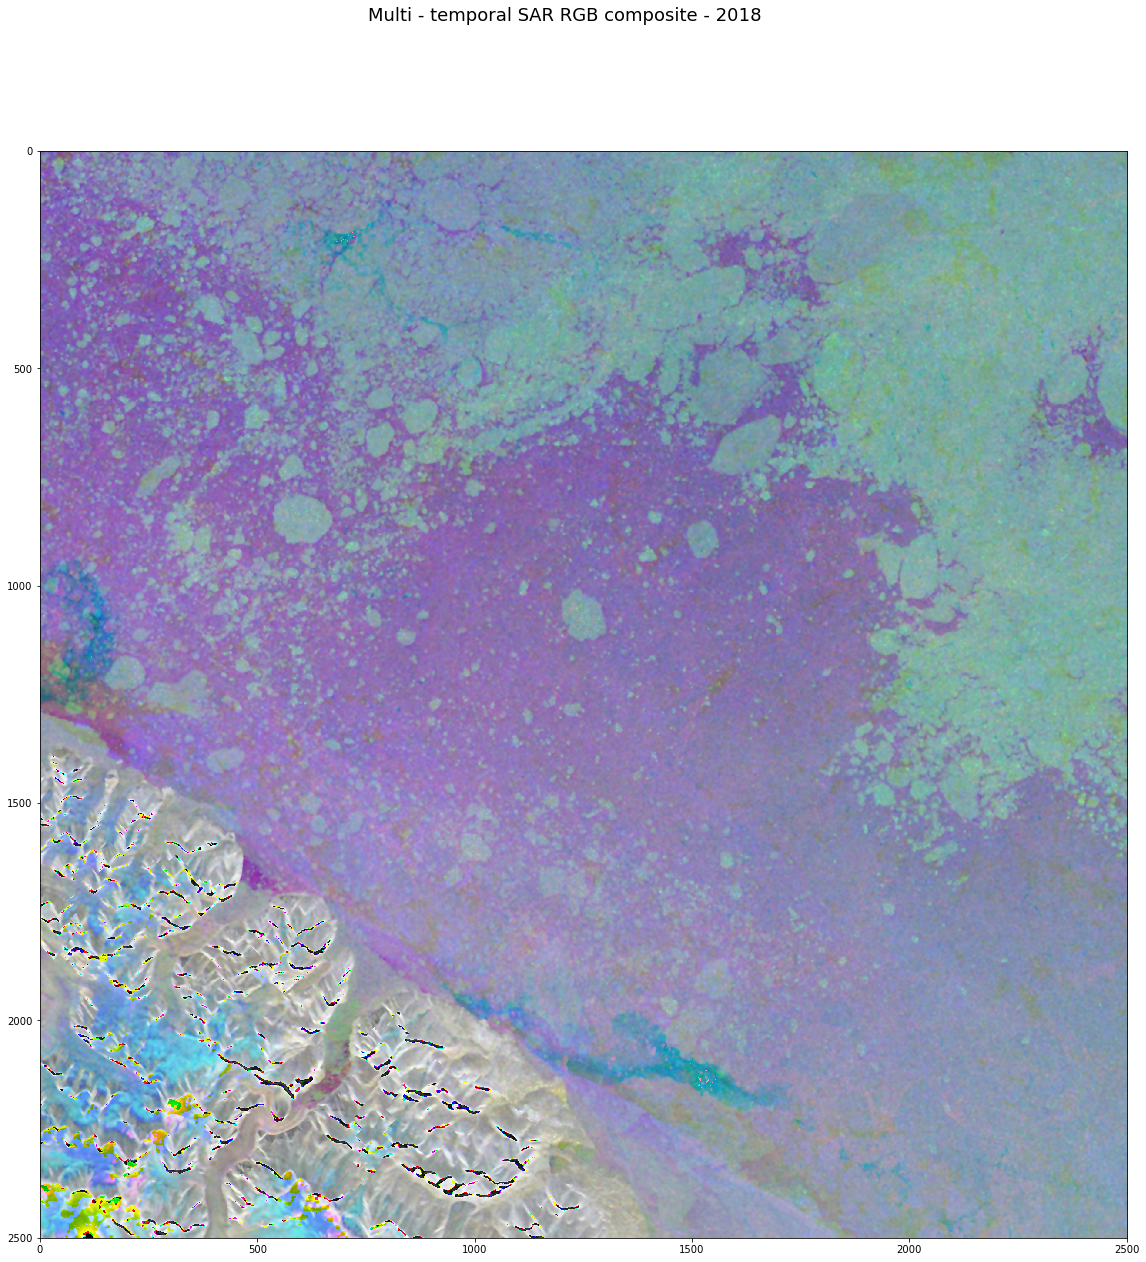

In [28]:
rgb_uint8 = np.dstack(bands).astype(np.uint8) 

width = 20
height = 20

fig = plt.figure(figsize=(width, height))

fig.suptitle('Multi - temporal SAR RGB composite - 2018', fontsize=18)

img = Image.fromarray(rgb_uint8)
imgplot = plt.imshow(img)

### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.